In [1]:
import numpy as np
import numpy.random as rng
from scipy.integrate import odeint
from scipy.optimize import minimize, root
import matplotlib.pyplot as plt

import sys
import os
current_notebook_dir = os.getcwd()
# Replace with the path to your IT_PI.py function
project_root_dir = os.path.join(current_notebook_dir, '..', '..')
it_pi_module_dir = project_root_dir
sys.path.append(it_pi_module_dir)
import IT_PI
from numpy.linalg import inv, matrix_rank
from pprint import pprint
plt.rcParams['font.family'] = 'Times New Roman'  # Set the font to Times New Roman
plt.rcParams['text.usetex'] = True 

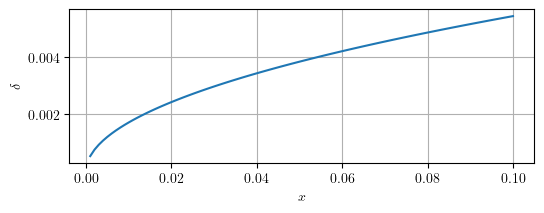

In [2]:
##Generate the data
eta_inf = 10;  # Arbitrary "infinite" upper limit for domain
d_eta = 0.01;   # Step size
eta = np.arange(0, eta_inf, d_eta)

F_init = [0, 0, 0] # Initial guess for unknown initial condition
def blasius_rhs(f):
    """RHS of Blasius equation recast as first order nonlinear ODE
    f[0] = f
    f[1] = f'
    f[2] = f''
    """
    return np.array([f[1], f[2], -f[0]*f[2]/2])

def bc_fn(f0):
    """Solve with unknown initial condition as guess and evaluate at upper boundary"""
    global eta
    f = odeint(lambda f, t: blasius_rhs(f), f0, eta)
    # return discrepancy between upper boundary and desired f[2] = 1
    return [f0[0], f0[1], f[-1, 1] - 1]
# Solve root-finding problem for unknown initial condition
opt_res = root(bc_fn, F_init, tol=1e-4)
F0 = [0, 0, opt_res.x[2]]

# Evaluate with resulting initial conditions
f = odeint(lambda y, t: blasius_rhs(y), F0, eta)
x = np.linspace(1e-3, 1e-1, 100)
nu = 1e-6       # Viscosity of water near room temperature  (m^2/s)
U_inf = 0.01    # m/s

Re = (U_inf/nu)*x
delta = 1.72 * np.sqrt(x*nu/U_inf)

plt.figure(figsize=(6, 2))
plt.plot(x, delta)
plt.grid()
plt.xlabel('$x$')
plt.ylabel(r'$\delta$')

y = np.linspace(1e-4, 2*max(delta), 100)

yy, xx = np.meshgrid(y, x)

u = np.zeros([len(x), len(y)])
v = np.zeros(u.shape)

eta = yy*np.sqrt(U_inf/(xx*nu))  # Exact value of eta

for i in range(len(x)):
    f = odeint(lambda y, t: blasius_rhs(y), F0, eta[i, :])
    u[i, :] = U_inf * f[:, 1]
    v[i, :] = (0.5*U_inf/np.sqrt(Re[i])) * (eta[i, :]*f[:, 1] - f[:, 0])

Text(0, 0.5, '$y$')

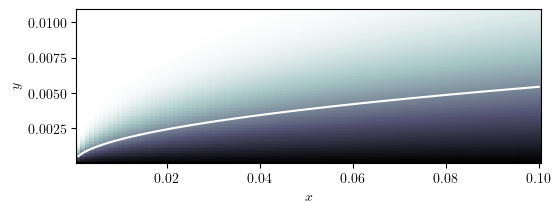

In [3]:
plt.figure(figsize=(6, 2))
plt.pcolor(x, y, u.T, shading='auto', cmap='bone')
plt.plot(x, delta, c='w')
plt.xlabel("$x$")
plt.ylabel("$y$")

In [4]:
q = np.vstack([u.flatten()/U_inf, v.flatten()/U_inf]).T
# All parameters
p = np.vstack([np.full(u.shape, U_inf).flatten(),
               np.full(u.shape, nu).flatten(),xx.flatten(),
               yy.flatten()]).T


In [5]:
Y                = q[:,0]
Y = Y.reshape(-1, 1)
X                = p
variables_tauw   = [ 'U','\\nu','x','y'];                       #Define variable name
D_in             = np.matrix(' 1 2 1 1; -1 -1 0 0')                           #Define D_in matrix 
num_input        = 1


In [6]:
print("Rank of D_in:", matrix_rank(D_in))
print("D_in matrix:\n", D_in)
num_rows          = np.shape(D_in)[0]
num_cols          = np.shape(D_in)[1]
# Function to calculate basis matrices

# Generate basis matrices
num_basis        = D_in.shape[1] -matrix_rank(D_in)
basis_matrices   = IT_PI.calc_basis(D_in, num_basis)
print("Basis vectors:")
pprint(basis_matrices)

Rank of D_in: 2
D_in matrix:
 [[ 1  2  1  1]
 [-1 -1  0  0]]
Basis vectors:
matrix([[-1.,  1., -1.,  0.],
        [-1.,  1.,  0., -1.]])


In [7]:
# Run dimensionless learning
results = IT_PI.main(
    X,
    Y.reshape(-1, 1),
    basis_matrices,
    num_input=num_input,
    estimator="binning",
    estimator_params={"num_bins": 60},
    seed=42
)


input_PI = results["input_PI"]
epsilon  = results["irreducible_error"]
uq       = results["uncertainty"]

------------------------------------------------------------
num of parameters: 2

Using estimator: 'binning' with hyperparameters: {'num_bins': 60}

(150_w,300)-aCMA-ES (mu_w=78.0,w_1=3%) in dimension 2 (seed=42, Sun Jul 27 15:32:42 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    300 -2.654255729820969e+00 1.0e+00 5.73e-01  3e-01  6e-01 0:00.5
    2    600 -2.742721603884381e+00 2.4e+00 5.81e-01  3e-01  6e-01 0:00.9
    3    900 -2.804042518946249e+00 8.1e+00 6.59e-01  2e-01  5e-01 0:01.4
    9   2700 -2.844925197055926e+00 5.1e+01 1.25e+00  3e-02  7e-02 0:04.5
   17   5100 -2.854241275069175e+00 1.9e+02 1.35e+00  2e-02  4e-02 0:08.5
   27   8100 -2.847159991481758e+00 4.3e+01 1.33e+00  2e-03  4e-03 0:13.6
   39  11700 -2.848595536506156e+00 1.3e+01 2.92e+00  8e-05  3e-04 0:19.7
   53  15900 -2.848897200317003e+00 3.0e+01 8.04e+00  2e-06  6e-06 0:27.1
   57  17100 -2.848879036338623e+00 5.1e+01 7.17e+00  1e-06  4e-06 0:29.1
termination on tolflat

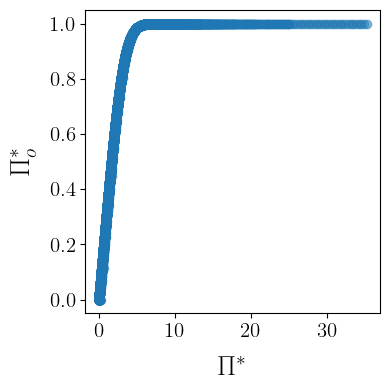

In [8]:
output_PI = results["output_PI"]
IT_PI.plot_scatter(input_PI,output_PI)